<a href="https://colab.research.google.com/github/gkadusumilli/3D_pointcloud_classifier/blob/master/3D_object_classifier_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D Object detection classifier

[Refer this blog for the detailed instructions](https://https://medium.com/@gkadusumilli/3d-object-classification-in-6-steps-using-kaolin-and-colab-9ecb079143a8) 



In [14]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
!pip install tqdm
from tqdm import *

tf.random.set_seed(1234)
%matplotlib inline

In [3]:
!git clone https://github.com/gkadusumilli/kaolin_1.git

Cloning into 'kaolin_1'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (519/519), done.
remote: Compressing objects: 100% (402/402), done.
remote: Total 519 (delta 94), reused 519 (delta 94), pack-reused 0
Receiving objects: 100% (519/519), 44.60 MiB | 31.07 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [4]:
%cd /content/kaolin_1/Documents/kaolin-0.1
!python setup.py build_ext --inplace

/content/kaolin_1/Documents/kaolin-0.1
WARNING - Kaolin is tested with PyTorch >=1.2.0, <1.5.0 Found version 1.9.0+cu111 instead.
WARNING - Kaolin is tested with torchvision >=0.4.0, <0.6.0 Found version 0.10.0+cu111 instead.
Building nv-usd...
sh: 1: ./buildusd.sh: Permission denied
running build_ext
building 'kaolin.triangle_hash' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/kaolin
creating build/temp.linux-x86_64-3.7/kaolin/cython
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -Wno-deprecated-declarations -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch

In [5]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473415680/473402300 [==============================] - 6s 0us/step


In [6]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [7]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

In [15]:
import torch
from torch.utils.data import DataLoader
!pip install pptk
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier
import kaolin.transforms as tfs
from torchvision.transforms import Lambda

In [16]:
modelnet_path = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
print(modelnet_path)
categories = ['chair', 'sofa', 'bed','night_stand']
num_points=1024
device='cuda'
workers = 8

#training parameters
batch_size = 12
learning_rate = 1e-3
epochs = 10



/root/.keras/datasets/ModelNet10


In [17]:
def to_device(inp):
    inp.to(device)
    return inp

transform = tfs.Compose([
    to_device,
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

num_workers = 0 if device == 'cuda' else workers
pin_memory = device != 'cuda'

In [18]:
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform),
                          batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=pin_memory)

In [19]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform),
                        batch_size=batch_size, num_workers=num_workers,
                        pin_memory=pin_memory)

In [20]:
model = PointNetClassifier(num_classes=len(categories)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [21]:

for e in range(epochs):
    print(f'{"":-<10}\nEpoch: {e}\n{"":-<10}')

    train_loss = 0.
    train_accuracy = 0.

    model.train()
    for batch_idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].to(device)
        pred = model(data)
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Train loss:', train_loss / len(train_loader))
    print('Train accuracy:', train_accuracy / len(train_loader))

    val_loss = 0.
    val_accuracy = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].to(device)
            pred = model(data)
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Val loss:', val_loss / len(val_loader))
    print('Val accuracy:', val_accuracy / len(val_loader))

----------
Epoch: 0
----------


100%|██████████| 191/191 [05:17<00:00,  1.66s/it]


Train loss: 0.3991523653424847
Train accuracy: 0.8595113634907138


100%|██████████| 33/33 [00:40<00:00,  1.24s/it]


Val loss: 0.334680631079457
Val accuracy: 0.8863636490070459
----------
Epoch: 1
----------


100%|██████████| 191/191 [05:15<00:00,  1.65s/it]


Train loss: 0.3059343500696708
Train accuracy: 0.9018324763362945


100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Val loss: 0.4047793924074733
Val accuracy: 0.9015151605461583
----------
Epoch: 2
----------


100%|██████████| 191/191 [05:18<00:00,  1.67s/it]


Train loss: 0.2594162921240817
Train accuracy: 0.9188481815822461


100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Val loss: 1.1855440591320847
Val accuracy: 0.5984848613540331
----------
Epoch: 3
----------


100%|██████████| 191/191 [05:17<00:00,  1.66s/it]


Train loss: 0.2272024075476287
Train accuracy: 0.924956383817483


100%|██████████| 33/33 [00:41<00:00,  1.27s/it]


Val loss: 0.16514519926612126
Val accuracy: 0.944444452271317
----------
Epoch: 4
----------


100%|██████████| 191/191 [05:18<00:00,  1.67s/it]


Train loss: 0.24385930254996915
Train accuracy: 0.9210296806864714


100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Val loss: 0.2745397105587251
Val accuracy: 0.9065656680049319
----------
Epoch: 5
----------


100%|██████████| 191/191 [05:18<00:00,  1.67s/it]


Train loss: 0.2186405403900365
Train accuracy: 0.9297556852170934


100%|██████████| 33/33 [00:41<00:00,  1.25s/it]


Val loss: 0.21373199028047649
Val accuracy: 0.9469697060007037
----------
Epoch: 6
----------


100%|██████████| 191/191 [05:17<00:00,  1.66s/it]


Train loss: 0.20393593414779265
Train accuracy: 0.929755684592961


100%|██████████| 33/33 [00:41<00:00,  1.25s/it]


Val loss: 0.2296799294594111
Val accuracy: 0.9040404196941492
----------
Epoch: 7
----------


100%|██████████| 191/191 [05:17<00:00,  1.66s/it]


Train loss: 0.1736494867004337
Train accuracy: 0.9406631885398745


100%|██████████| 33/33 [00:41<00:00,  1.25s/it]


Val loss: 0.3626823546788232
Val accuracy: 0.8611111189379836
----------
Epoch: 8
----------


100%|██████████| 191/191 [05:19<00:00,  1.67s/it]


Train loss: 0.17096977418103299
Train accuracy: 0.9376090877343223


100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Val loss: 0.3633408915590156
Val accuracy: 0.8712121320493293
----------
Epoch: 9
----------


100%|██████████| 191/191 [05:20<00:00,  1.68s/it]


Train loss: 0.1693728163799378
Train accuracy: 0.9437172887212943


100%|██████████| 33/33 [00:41<00:00,  1.27s/it]

Val loss: 0.2205707675664488
Val accuracy: 0.9318181908491886


In [22]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                  split='test',transform=transform),
                        shuffle=True, batch_size=15)

data, attr = next(iter(test_loader))
data = data.to('cuda')
labels = attr['category'].to('cuda')
preds = model(data)
pred_labels = torch.max(preds, axis=1)[1]

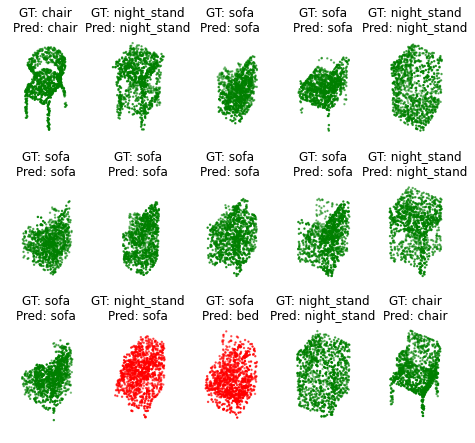

In [23]:

from mpl_toolkits.mplot3d import Axes3D     # unused import necessary to have access to 3d projection # noqa: F401
import matplotlib.pyplot as plt
%matplotlib inline


def visualize_batch(pointclouds, pred_labels, labels, categories):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))

    ncols = 5
    nrows = max(1, batch_size // 5)
    for idx, pc in enumerate(pointclouds):
        label = categories[labels[idx].item()]
        pred = categories[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))

    plt.show()
visualize_batch(data, pred_labels, labels, categories)
